<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/FYPResNet01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from shutil import copy2
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Install necessary libraries
!pip install tensorflow_hub

# Set precision for pandas display
pd.set_option("display.precision", 8)

# Verify TensorFlow version
print(tf.__version__)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Set the data root directory
data_root = "/content/drive/My Drive/FYP/Dataset/train"

# Image size for resizing
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerators with augmentation and validation split
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Define training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_root,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

valid_generator = valid_datagen.flow_from_directory(
    data_root,
    subset="validation",
    shuffle=False,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

# Print class indices
print("Class Indices:", train_generator.class_indices)


Found 743 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Class Indices: {'Glaucous_Winged_Gull': 0, 'Slaty_Backed_Gull': 1}


In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Load ResNet50 model with pre-trained ImageNet weights, exclude the top layer
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze base model layers
base_model.trainable = False

# Define the model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Early stopping and checkpoint with .keras extension
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/My Drive/FYP/MODELS/resnet50_best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 245s 8s/step - accuracy: 0.4592 - loss: 0.9491 - val_accuracy: 0.4375 - val_loss: 0.6994
Epoch 2/40
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - accuracy: 0.5000 - loss: 0.8134

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5000 - loss: 0.8134 - val_accuracy: 0.0000e+00 - val_loss: 0.7375
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - accuracy: 0.5035 - loss: 0.8044 - val_accuracy: 0.4437 - val_loss: 0.7267
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.6875 - loss: 0.7302 - val_accuracy: 1.0000 - val_loss: 0.5422
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.4783 - loss: 0.7937 - val_accuracy: 0.4437 - val_loss: 0.7788
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.6562 - loss: 0.6427 - val_accuracy: 1.0000 - val_loss: 0.4061
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.4879 - loss: 0.7562 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6875 - loss: 0.6432 - val_accuracy: 1.0000 - val_loss: 0.6032
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.5278 - loss: 0.7319 - val_accuracy: 0.5625 - val

In [ ]:
# Save the final model
model.save('/content/drive/My Drive/FYP/MODELS/resnet50_final_model.keras')

# Load the model (when needed)
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/FYP/MODELS/resnet50_best_model.keras')


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(valid_generator, verbose=2)
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")


6/6 - 37s - 6s/step - accuracy: 0.5163 - loss: 0.7402
Validation Loss: 0.7401685118675232
Validation Accuracy: 0.5163043737411499


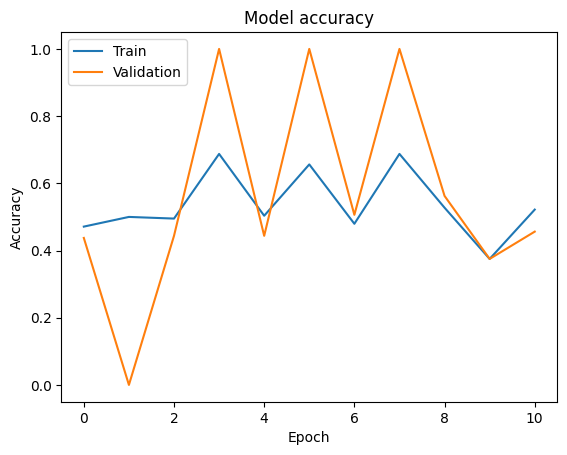

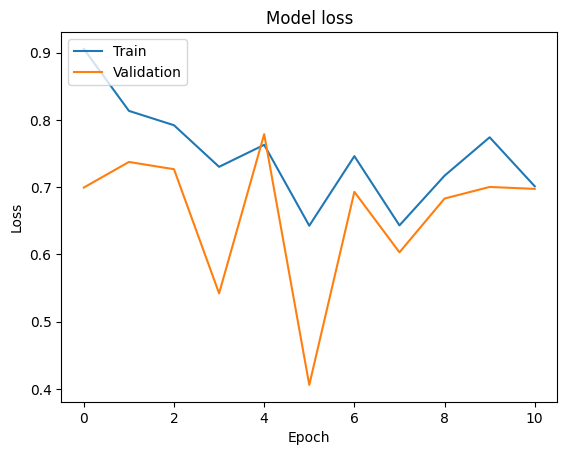

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save the best model
# Save the model in Keras format instead of HDF5 (.h5)
model.save('/content/drive/My Drive/FYP/MODELS/resnet50_best_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/1200 - 2024-08-18T191835.473.jpeg'

In [ ]:
# Load the model in Keras format
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/FYP/MODELS/resnet50_best_model.keras')

# Load and preprocess the image for prediction
img_path = '/content/1200 - 2024-08-18T191833.742.jpeg'
img = image.load_img(img_path, target_size=IMAGE_SHAPE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print(f"Predicted class: {list(train_generator.class_indices.keys())[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Slaty_Backed_Gull
